# Проведём исследование данных по прохождению студентами тестов

Для исследования предоставлены следующие данные:
- `lectures.csv`
- `questions.csv`
- `train.csv`


Цель исследования:
- Проанализировать статистические характеристики всех признаков
- Выявить влияние каждого признака на целевую переменную — успеваемость студента

# Первичный анализ

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.gridspec as gridspec

In [2]:
lectures_df = pd.read_csv('ftp://sebulbaass.ml/lectures.csv')
lectures_df

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


Рассмотрим столбцы:
- `lecture_id` - id лекции, внешний ключ
- `tag` - просто какой-то лэйбл, который присвоили лекции
- `part` - обозначение блока или раздела лекций
- `type_of` - цель лекции

In [3]:
questions_df = pd.read_csv('ftp://sebulbaass.ml/questions.csv')
questions_df

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


Рассмотрим столбцы:
- `question_id` - внешний ключ и уникальный идентификатор вопроса
- `bundle_id` - группа вопросов
- `correct_answer` - правильный ответ на вопрос
- `part` - раздел теста под названием TOEIC
- `tags` - просто какие-то коды вопросов, их можно применить для кластеризации

In [4]:
train_df = pd.read_csv('ftp://sebulbaass.ml/train.csv')
train_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
101230327,101230327,428564420,2147482888,3586,0,22,0,1,18000.0,True
101230328,101230328,428585000,2147482888,6341,0,23,3,1,14000.0,True
101230329,101230329,428613475,2147482888,4212,0,24,3,1,14000.0,True
101230330,101230330,428649406,2147482888,6343,0,25,1,0,22000.0,True


Рассмотрим столбцы:
- `row_id` - уникальный идентификатор строки
- `timestamp` - время в миллисекундах между первым завершённым событием этого пользователя и текущим событием
- `user_id` - идентификатор пользователя
- `content_id` - идентификатор лекции или вопросов
- `content_type_id` - тип предыдущего идентификатора 0, если вопрос, 1, если лекция
- `task_container_id` - 
- `user_answer` - ответ пользователя
- `answered_correctly` - ответил ли пользователь корректно
- `prior_question_elapsed_time` - среднее время ответа в прошлой связке заданий
- `prior_question_had_explanation` - получил ли пользователь обраную связь после решения прошолой связки вопросов

# Предобработка данных

В итоге для работы нам нужно получить датасет:
- `ques_events`

Только один, потому что в описании данных не сказано каким образом данные по вопросам, где есть наша целевая переменная - `answered_correctly` с лекционной частью данных, кроме как простого "да" или "нет" на вопрос: "Получил ли ученик обратную связь"

Для этого нам нужно разделить датафрейм `train_df` и дополнить информацией об самом ивенте из датафрейма `questions_df`

In [5]:
ques_events = train_df[train_df.content_type_id == 0]
ques_events = ques_events.merge(questions_df, left_on='content_id', right_on='question_id')
ques_events

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags
0,0,0,115,5692,0,1,3,1,NaN,NaN,5692,5692,3,5,151
1,2385,4216576228,24418,5692,0,497,3,1,21000.0,True,5692,5692,3,5,151
2,8954,0,51285,5692,0,0,3,1,NaN,NaN,5692,5692,3,5,151
3,9280,330907575,91216,5692,0,153,3,1,22000.0,True,5692,5692,3,5,151
4,13269,560202977,138650,5692,0,122,3,1,18000.0,True,5692,5692,3,5,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99271295,89256667,7327293505,1896513376,5823,0,4239,0,1,21000.0,True,5823,5823,0,5,8
99271296,97579050,4339553896,2070144393,10008,0,1406,3,1,23750.0,False,10008,10005,3,6,55
99271297,97579051,4339553896,2070144393,10007,0,1406,1,0,23750.0,False,10007,10005,0,6,27
99271298,97579052,4339553896,2070144393,10006,0,1406,0,1,23750.0,False,10006,10005,0,6,73


## Обработка пропусков

In [6]:
ques_events.isna().sum()

row_id                                 0
timestamp                              0
user_id                                0
content_id                             0
content_type_id                        0
task_container_id                      0
user_answer                            0
answered_correctly                     0
prior_question_elapsed_time       392506
prior_question_had_explanation    392506
question_id                            0
bundle_id                              0
correct_answer                         0
part                                   0
tags                                   1
dtype: int64

природа этих пропусков известна, если пользователь ответил на первый вопрос в текущей группе, в данных полях ставится NaN, признак `tags` также может быть неизвестен

## Приведение типов

In [7]:
ques_events.dtypes

row_id                              int64
timestamp                           int64
user_id                             int64
content_id                          int64
content_type_id                     int64
task_container_id                   int64
user_answer                         int64
answered_correctly                  int64
prior_question_elapsed_time       float64
prior_question_had_explanation     object
question_id                         int64
bundle_id                           int64
correct_answer                      int64
part                                int64
tags                               object
dtype: object

`prior_question_had_explanation` должна быть булевой переменной, нужно исправить

In [8]:
ques_events.prior_question_had_explanation = ques_events.prior_question_had_explanation.astype('bool')
ques_events.dtypes

row_id                              int64
timestamp                           int64
user_id                             int64
content_id                          int64
content_type_id                     int64
task_container_id                   int64
user_answer                         int64
answered_correctly                  int64
prior_question_elapsed_time       float64
prior_question_had_explanation       bool
question_id                         int64
bundle_id                           int64
correct_answer                      int64
part                                int64
tags                               object
dtype: object

## Аномалии

<AxesSubplot:xlabel='timestamp', ylabel='Count'>

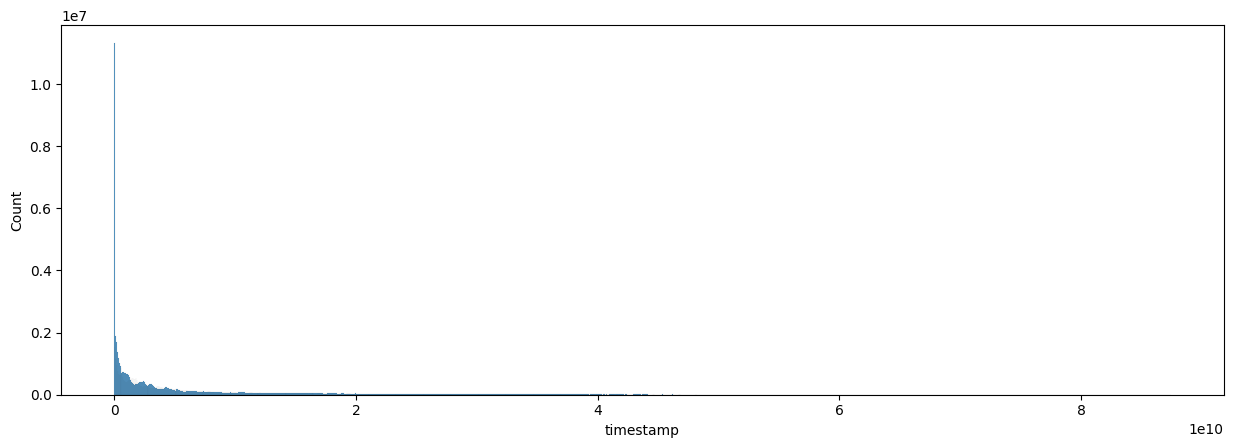

In [ ]:
fig = plt.figure()
fig.set_figwidth(15)

sns.histplot(ques_events.timestamp)

Очень много событий с нулевым признаком `timestamp` это можно объяснить тем, время считается и в тот момент, когда ответ дают на первом вопросе в группе

Также видим длинный хвост для таких временных данных это нормально, логично, что не все студенты быстро решили вопросы, и та небольшая часть, что дошли до конца, решают вопросы с разной скоростью.

<AxesSubplot:xlabel='prior_question_elapsed_time', ylabel='Count'>

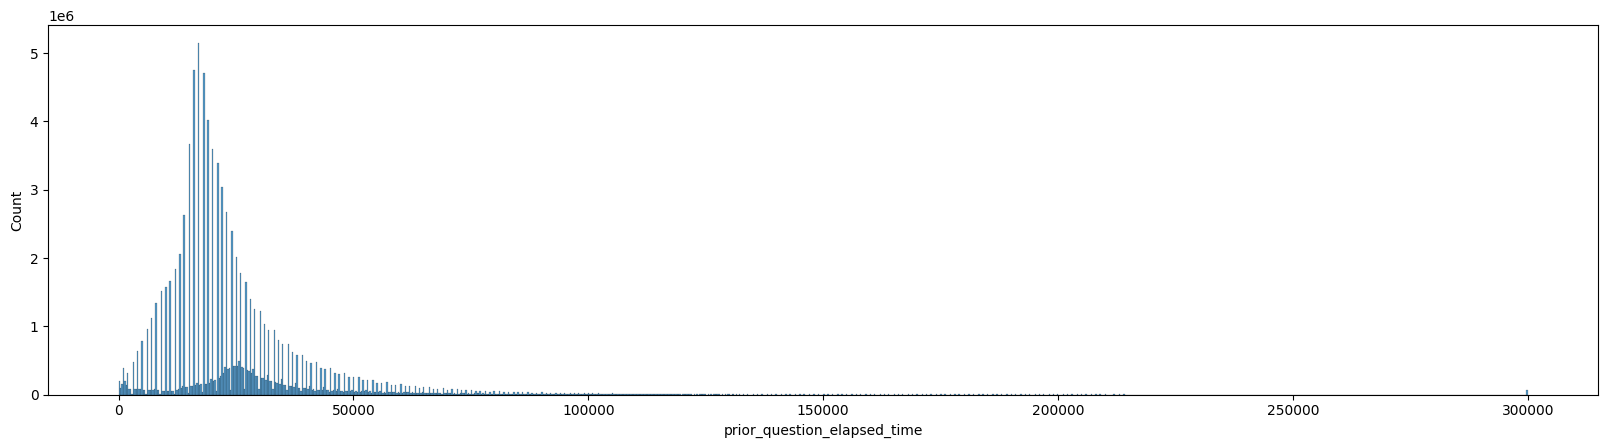

In [ ]:
fig = plt.figure()
fig.set_figwidth(20)

sns.histplot(data=ques_events, x='prior_question_elapsed_time', bins=1000)

Тут тоже всё в порядке, так как тут значения средние для групп ответов, мы видим более нормальное распределение с длинным хвостом, опять же хвост может отвечать за более времязатратные вопросы, до которых не все дошли.

<AxesSubplot:xlabel='user_answer', ylabel='Count'>

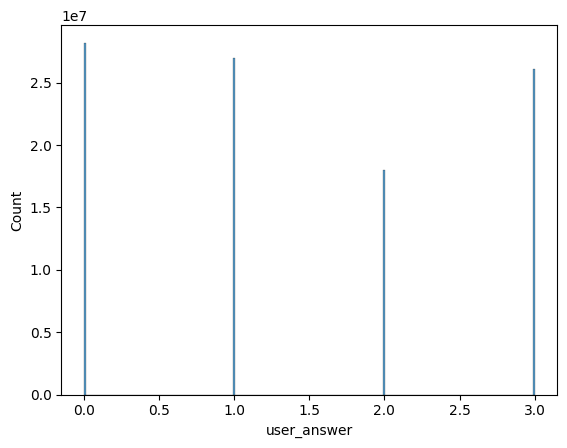

In [ ]:
sns.histplot(data=ques_events, x='user_answer')

<AxesSubplot:xlabel='bundle_id', ylabel='Count'>

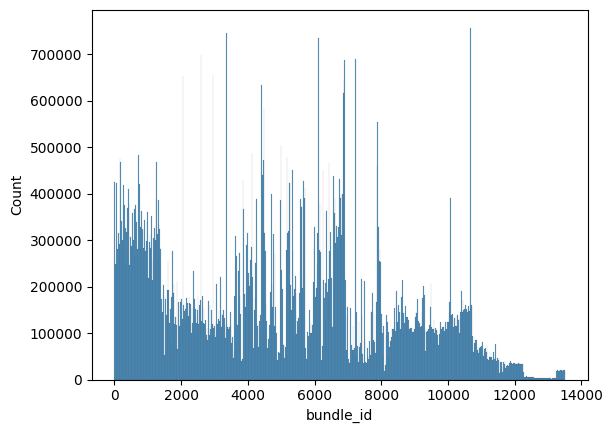

In [ ]:
sns.histplot(data=ques_events, x='bundle_id')

<AxesSubplot:xlabel='correct_answer', ylabel='Count'>

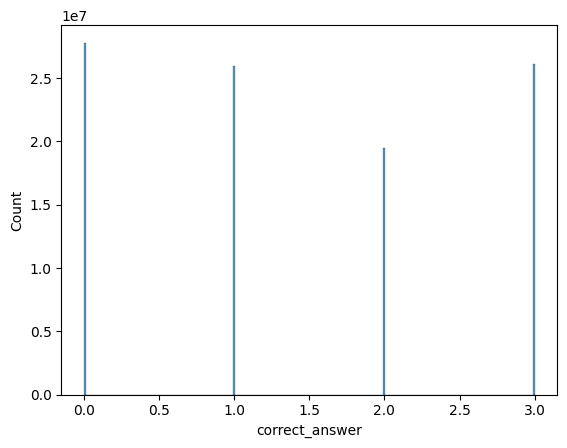

In [ ]:
sns.histplot(data=ques_events, x='correct_answer')

<AxesSubplot:xlabel='part', ylabel='Count'>

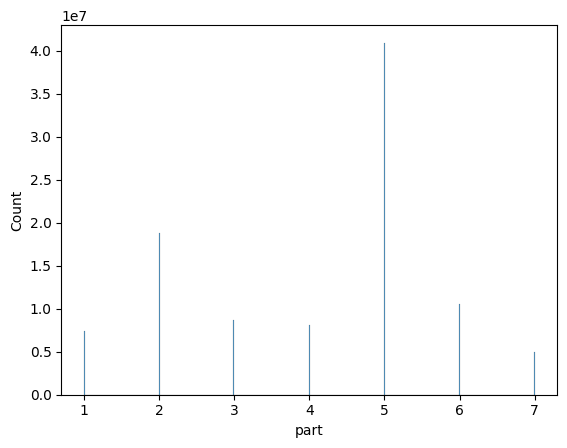

In [ ]:
sns.histplot(data=ques_events, x='part')

Остальные признаки это идентификаторы

# Проведём анализ признаков и посмотрим их влияение на успеваемость студентов

Посмотрим на статистические показатели количественных переменных

In [ ]:
ques_events[['prior_question_elapsed_time', 'timestamp']].applymap(lambda x: x/60000).describe().applymap("{0:.2f}".format)

,prior_question_elapsed_time,timestamp
count,98878794.00,99271300.00
mean,0.42,128367.64
std,0.33,193249.63
min,0.00,0.00
25%,0.27,8658.80
50%,0.35,44493.52
75%,0.49,165485.78
max,5.00,1457096.20


Проверим правильность стобца `answered_correctly`

In [ ]:
ques_events['answered_correctly_check'] = [s == j for s, j in zip(ques_events.user_answer, ques_events.correct_answer)] 
print(ques_events['answered_correctly_check'].sum(), ques_events.answered_correctly.sum())

65244627 65244627


Всё правильно

<AxesSubplot:xlabel='timestamp', ylabel='Count'>

<Figure size 1500x480 with 0 Axes>

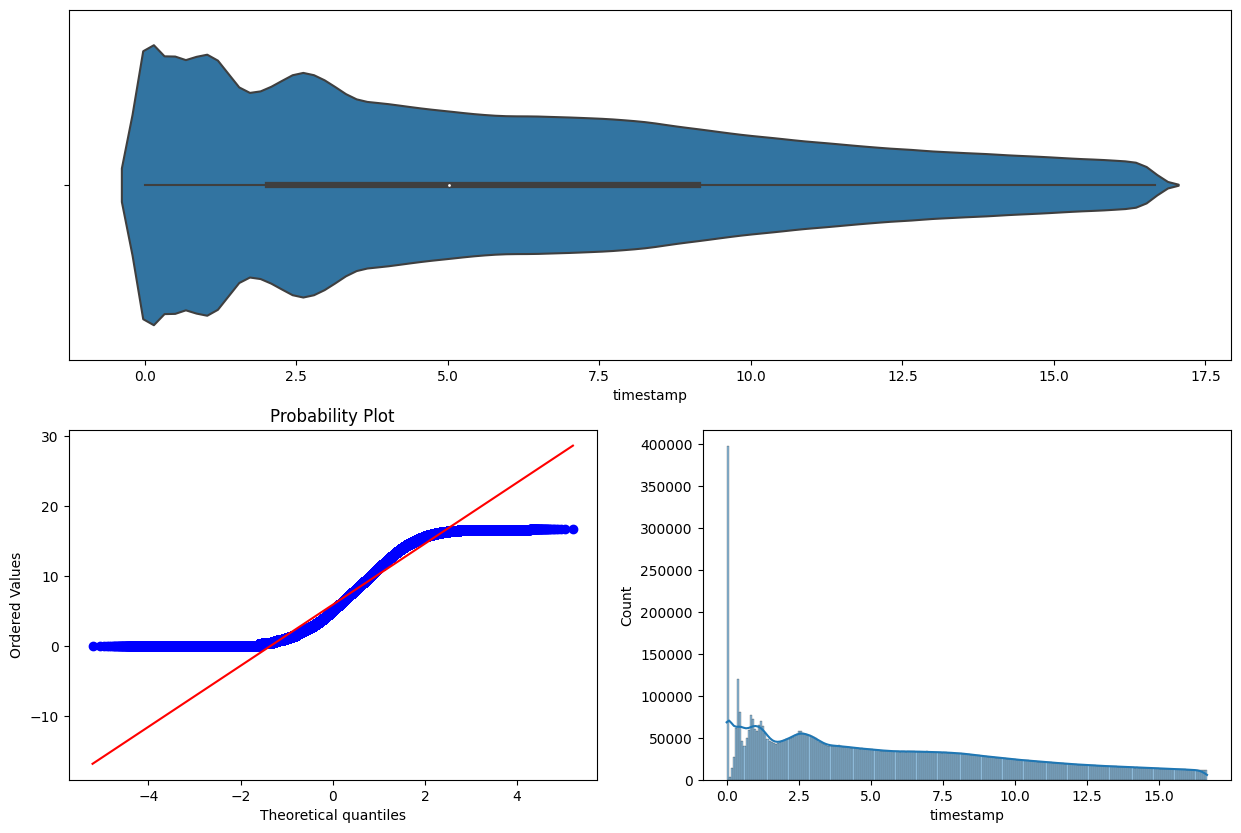

In [ ]:
fig = plt.figure()
fig.set_figwidth(15)

data_an = ques_events[ques_events.timestamp < 1000000].timestamp.apply(lambda x: x/60000)

fig = plt.figure()
gs = gridspec.GridSpec(2, 2)

fig.set_figheight(10)
fig.set_figwidth(15)

sns.violinplot(x=data_an, ax=plt.subplot(gs[0, 0:]))
stats.probplot(data_an, dist="norm", plot=plt.subplot(gs[1, 0]))

sns.histplot(data_an, kde=True, ax=plt.subplot(gs[1, 1]))

Видим, что чем сложнее задание, тем меньше людей его выполняют\
Также видим, что распределение более менее нормальное в середине, однако по краям сильно отходит, такие данные могут негативно повлиять на модель.

C:\Users\egors\AppData\Local\Temp\ipykernel_9872\959977892.py:17: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.histplot(data=data_an, x='prior_question_elapsed_time', kde=True, ax=plt.subplot(gs[1, 1]), bins=100, hue='part', palette=sns.color_palette("hls", 8))


<AxesSubplot:xlabel='prior_question_elapsed_time', ylabel='Count'>

<Figure size 1500x480 with 0 Axes>

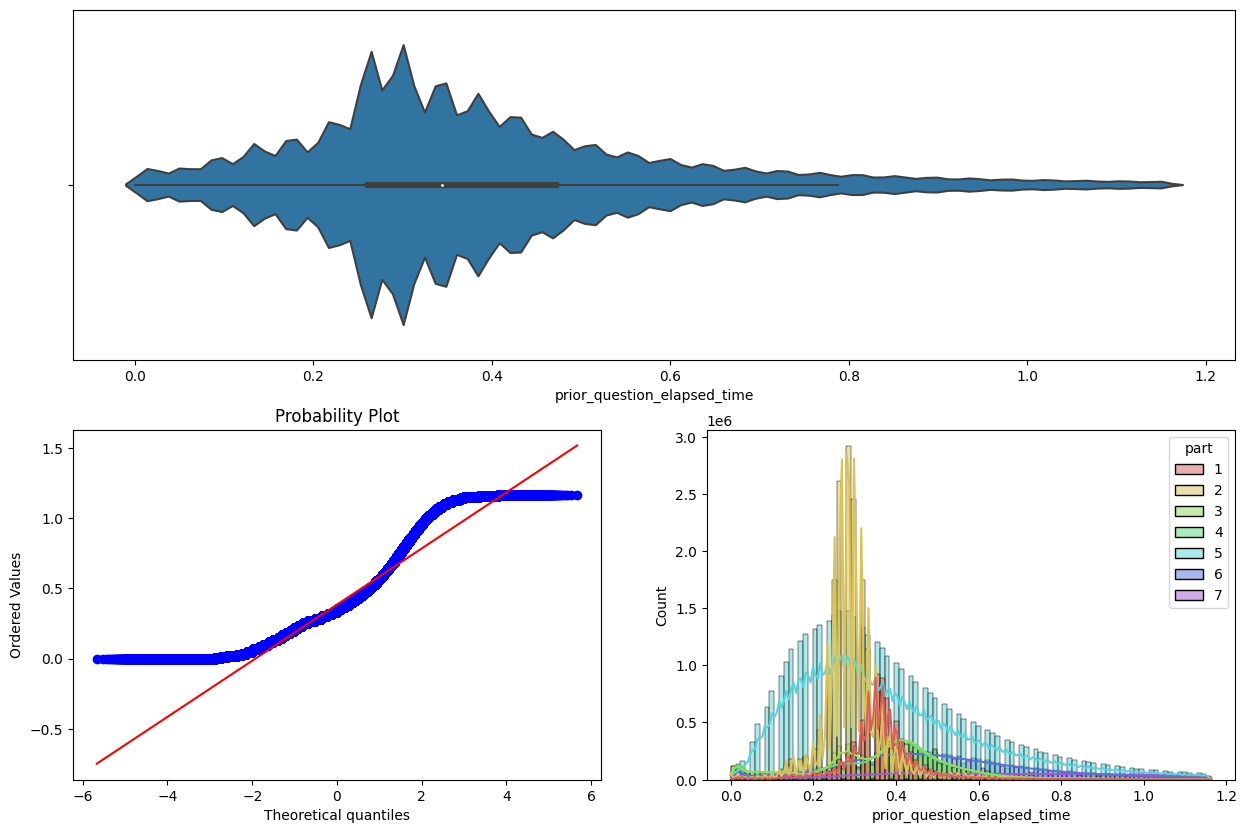

In [ ]:
fig = plt.figure()
fig.set_figwidth(15)

data_an = ques_events[ques_events.prior_question_elapsed_time < 70000][['prior_question_elapsed_time', 'part']]
data_an['prior_question_elapsed_time'] = data_an.prior_question_elapsed_time.apply(lambda x: x/60000)
data_an

fig = plt.figure()
gs = gridspec.GridSpec(2, 2)

fig.set_figheight(10)
fig.set_figwidth(15)

sns.violinplot(x=data_an['prior_question_elapsed_time'], ax=plt.subplot(gs[0, 0:]))
stats.probplot(data_an['prior_question_elapsed_time'], dist="norm", plot=plt.subplot(gs[1, 0]))

sns.histplot(data=data_an, x='prior_question_elapsed_time', kde=True, ax=plt.subplot(gs[1, 1]), bins=100, hue='part', palette=sns.color_palette("hls", 7))

В разрезе частей всего теста можно увидеть нормальное распределение почти во всех цветных графиках

## Проанализируем наш целевой признак - успеваемость студентов

<AxesSubplot:>

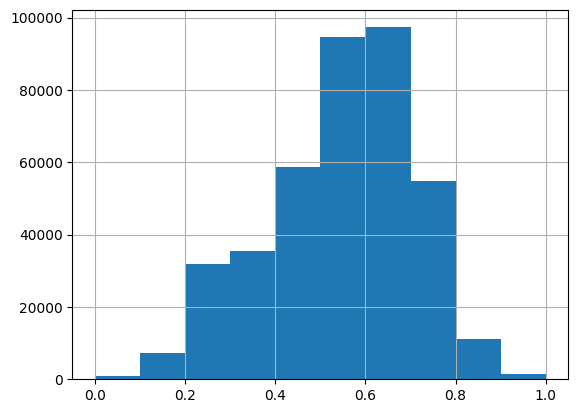

In [ ]:
(ques_events.groupby('user_id')['answered_correctly'].sum() / ques_events.groupby('user_id')['answered_correctly'].count()).hist()

Посмотрим на распределение потраченных минут в блоке заданий - `timestamp` на примере основной массы людей, т.е. на графике уберём хвост

In [22]:
group = ques_events[['user_id','answered_correctly','prior_question_elapsed_time']].groupby('user_id').sum().reset_index()
group_c = ques_events[['user_id','answered_correctly','prior_question_elapsed_time']].groupby('user_id').count().reset_index()

group['pers_corr'] = round(group['answered_correctly']/group_c['answered_correctly']*100)
group['count_corr'] = group_c['answered_correctly']
group['prior_question_elapsed_time'] = group['prior_question_elapsed_time'].apply(lambda x: x//60000)

group

,user_id,answered_correctly,prior_question_elapsed_time,pers_corr,count_corr
0,115,32,14.0,70.0,46
1,124,7,9.0,23.0,30
2,2746,11,5.0,58.0,19
3,5382,84,74.0,67.0,125
4,8623,70,46.0,64.0,109
...,...,...,...,...,...
393651,2147470770,173,86.0,77.0,226
393652,2147470777,520,250.0,69.0,752
393653,2147481750,38,14.0,76.0,50
393654,2147482216,177,89.0,64.0,275


<AxesSubplot:>

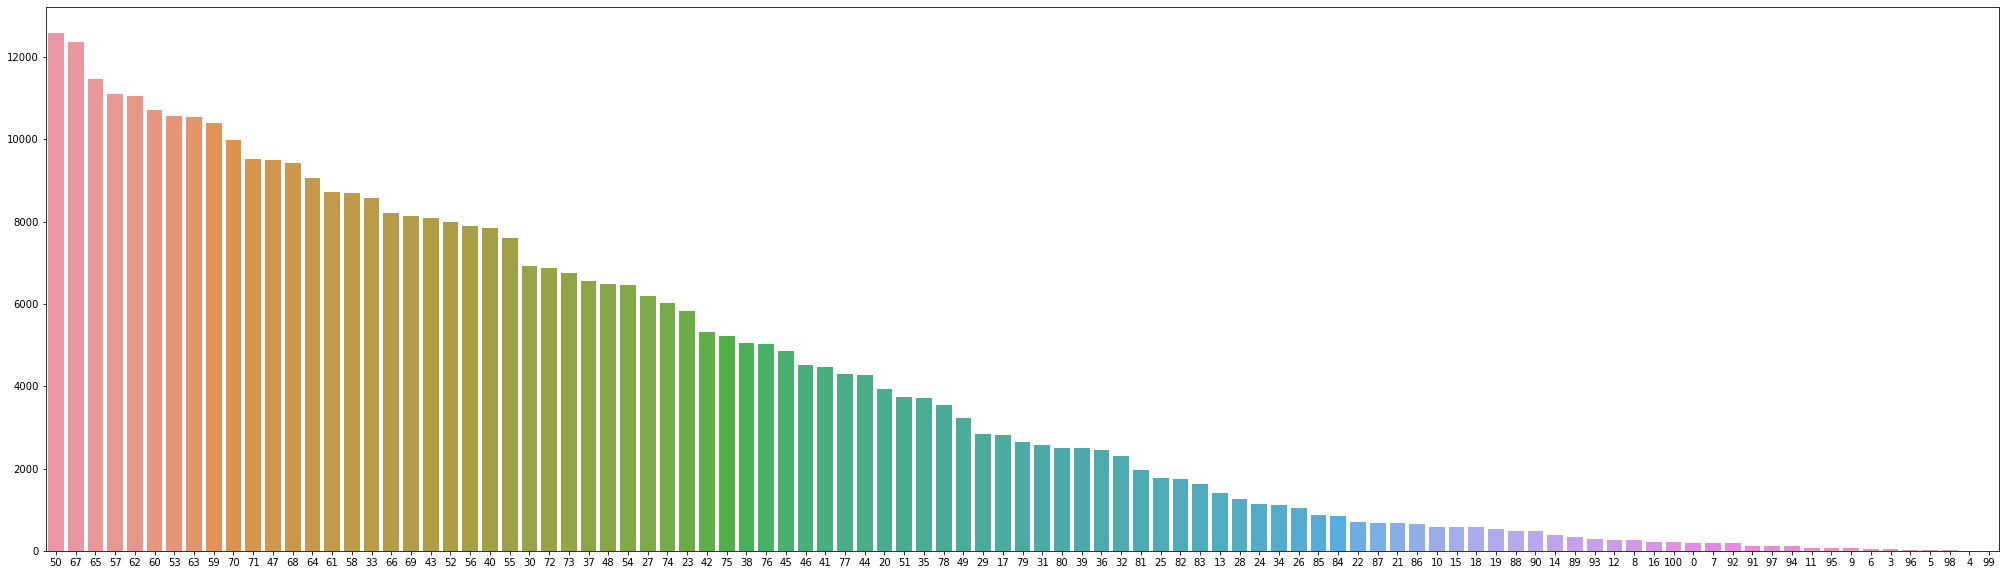

In [23]:
fig = plt.figure()
fig.set_figwidth(35)
fig.set_figheight(10)

pers = group['pers_corr'].value_counts()
sns.barplot(x=pers.index.astype('int'), y=pers.values, order=pers.index.astype('int'))

Здесь можем видеть количество студентов в разрезе целых процентов успеваемости, данный график не особо информативный, поэтому нарисуем боксплот, чтобы понять распределение

<AxesSubplot:>

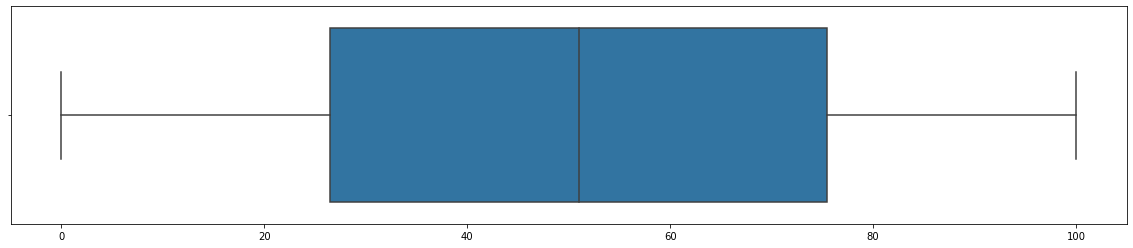

In [24]:
fig = plt.figure()
fig.set_figwidth(20)

pers = group['pers_corr'].value_counts()
sns.boxplot(x=pers.index.astype('int'))

Вот уже на этом графике прекрасно видно, что основная доля студентов - это 50% имеют успеваемость от 25% до 75%

<AxesSubplot:>

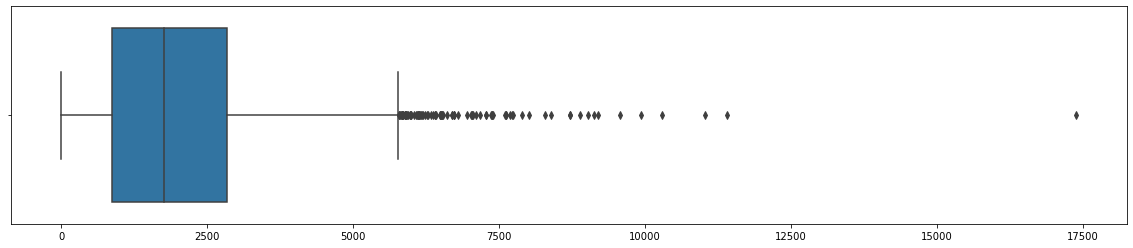

In [25]:
fig = plt.figure()
fig.set_figwidth(20)

mins = group['prior_question_elapsed_time'].value_counts()
sns.boxplot(x=mins.index.astype('int'))

Как видим, есть много значений, где на решенеие уходит больше 5 дней, однако, большинство людей решают задачи быстрее

<AxesSubplot:>

<Figure size 1440x288 with 0 Axes>

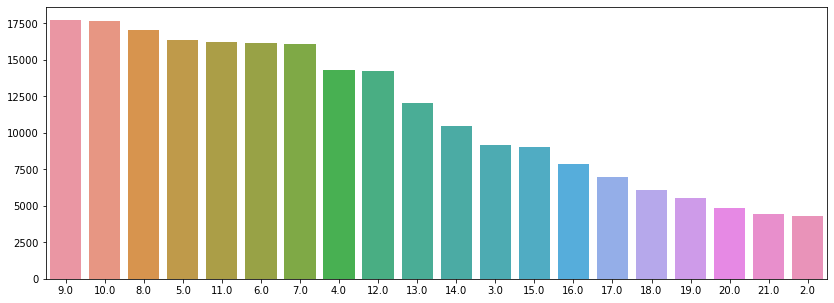

In [27]:
fig = plt.figure()
fig.set_figwidth(20)

mins = group['prior_question_elapsed_time'].value_counts()
plt.figure(figsize=(14,5))
sns.barplot(x=mins.index[:20], y=mins.values[:20], order=mins.index[:20])

На этом графике видно 20 самых больших групп по времени решения задач

## Корреляция

<AxesSubplot:>

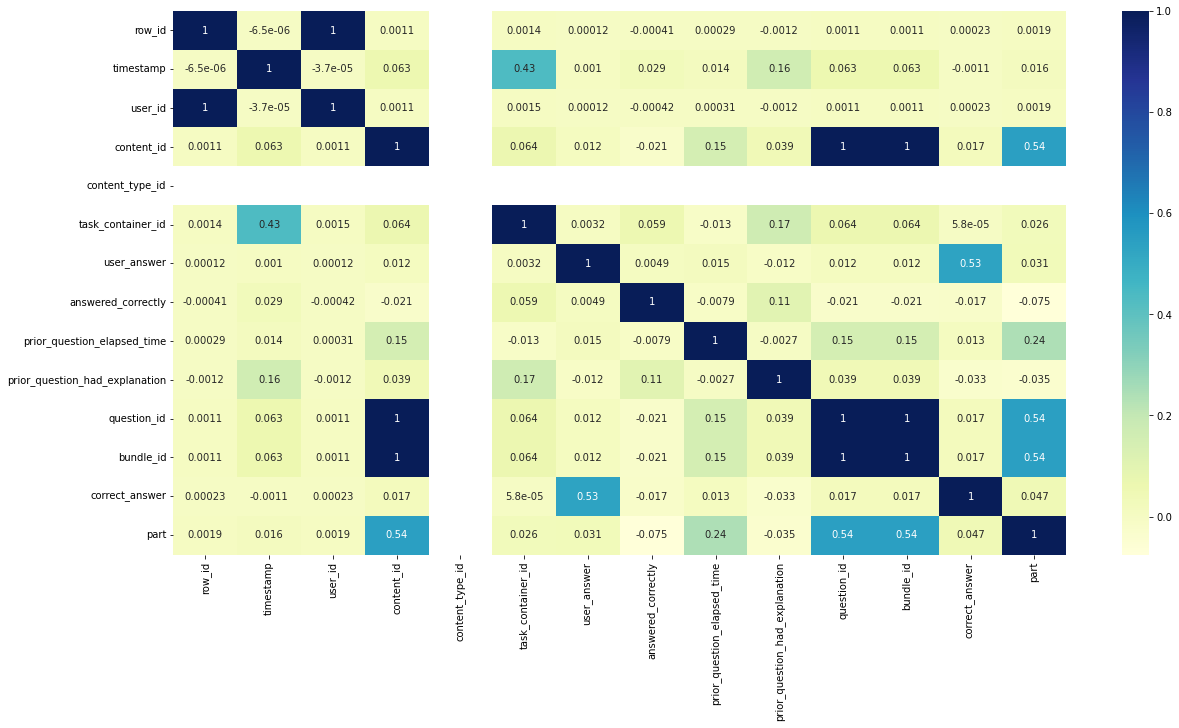

In [31]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)

sns.heatmap(ques_events.corr(), cmap="YlGnBu", annot=True)

Из матрицы корреляции мы видим, что наша переменная успеваемости частично зависит от ответов, которые дают студенты, что неудевительно. Остальные признаки имеют очень слабую корреляцию с целевым признаком.

C:\Users\egors\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<AxesSubplot:>

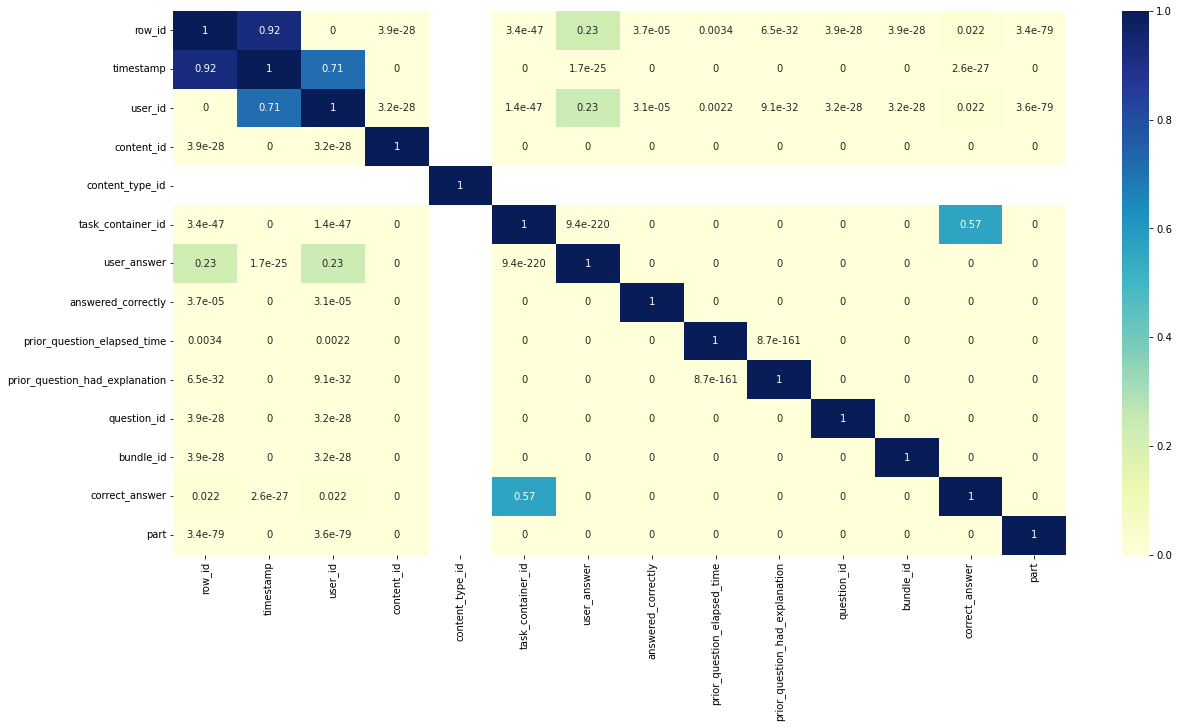

In [35]:
from scipy.stats import pearsonr

fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)


def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]

sns.heatmap(ques_events.corr(method=pearsonr_pval) , cmap="YlGnBu", annot=True)

Если рассматривать другой метод корреляции, то на успеваемость также влияет признак - `task_container_id`, то есть успеваемость зависит от того, каким образом сделали небольшую группу вопросов в промежутках между лекциями

In [43]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = ques_events[ques_events.prior_question_elapsed_time < 50000].drop(columns=['answered_correctly', 'tags'])
y = ques_events[ques_events.prior_question_elapsed_time < 50000]['answered_correctly']

bestfeatures = SelectKBest(score_func = chi2, k = 'all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']  
print(featureScores.nlargest(10, 'Score')) 

                             Specs         Score
1                        timestamp  1.459386e+15
2                          user_id  6.976447e+09
5                task_container_id  6.659271e+08
0                           row_id  3.236072e+08
10                       bundle_id  1.075109e+08
3                       content_id  1.075063e+08
9                      question_id  1.075063e+08
7      prior_question_elapsed_time  7.994062e+05
12                            part  4.173645e+05
8   prior_question_had_explanation  1.036844e+05


Здесь мы видим рейтинг фич, то есть можно уменьшить размер файла, убрав признаки, которые совсем слабо влияют на целевую переменную.

В итоге мы выяснили:
- Успеваемость зависит непосредственно от ответов студента
- Успеваемость зависит от групп, на которые разделены вопросы между лекциями